# Running Distributed TensorFlow on Vertex AI

## Overview


This tutorial demonstrates 
how to 

1.   Train a model using distribution strategies on Vertex AI using the SDK for Python
2.   Deploy a custom image classification model for online prediction using Vertex AI

### Dataset

The dataset used for this tutorial is the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist) from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview). The version of the dataset you will use is built into TensorFlow. The trained model predicts which type of class (digit) an image is from ten classes (0-9)

### Objective

In this notebook, you create a custom-trained model from a Python script in a Docker container using the Vertex SDK for Python, and then do a prediction on the deployed model by sending data. Alternatively, you can create custom-trained models using `gcloud` command-line tool, or online using the Cloud Console.

The steps performed include:

- Create a Vertex AI custom job for training a model in distributed fashion.
- Train the model using TensorFlow's `MirroredStrategy`.
- Deploy the `Model` resource to a serving `Endpoint` resource.
- Make a prediction.
- Undeploy the `Model` resource.

### Costs

This tutorial uses billable components of Google Cloud (GCP):

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the latest (preview) version of Vertex SDK for Python.

In [ ]:
import os

In [ ]:
! pip3 install --user --upgrade google-cloud-aiplatform

Install the latest GA version of *google-cloud-storage* library as well.

In [ ]:
! pip3 install --user --upgrade google-cloud-storage

Install the *pillow* library for loading images.

In [ ]:
! pip3 install --user --upgrade pillow

Install the *numpy* library for manipulation of image data.

In [ ]:
! pip3 install --user --upgrade numpy

You can safely ignore errors during the numpy installation.

In [ ]:
! pip3 install protobuf==3.20.1

### Restart the kernel

Once you've installed everything, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`. 

In [ ]:
import os

PROJECT_ID = ""

if not os.getenv("IS_TESTING"):
    # Get your Google Cloud project ID from gcloud
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you submit a training job using the Cloud SDK, you upload a Python package
containing your training code to a Cloud Storage bucket. Vertex AI runs
the code from this package. In this tutorial, Vertex AI also saves the
trained model that results from your job in the same bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
BUCKET_NAME = "gs://[your-bucket-name]"
REGION = "us-central1"  # @param {type:"string"}

In [ ]:
PROJECT_ID

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "gs://[your-bucket-name]":
    BUCKET_NAME = "gs://" + PROJECT_ID

**Only if your bucket doesn't already exist**: Run the following cells to create your Cloud Storage bucket.

In [ ]:
BUCKET_NAME

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

### Set up variables

Next, set up some variables used throughout the tutorial.

#### Import Vertex SDK for Python

Import the Vertex SDK for Python into your Python environment and initialize it.

In [ ]:
import os
import sys

from google.cloud import aiplatform
from google.cloud.aiplatform import gapic as aip

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME)

#### Set hardware accelerators

Here to run a container image on a CPU, we set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to `(None, None)` since this notebook is meant to be run in a Qwiklab environment where GPUs cannot be provisioned. 
  
Note: If you happen to be running this notebook from your personal GCP account, set the variables `TRAIN_GPU/TRAIN_NGPU` and `DEPLOY_GPU/DEPLOY_NGPU` to use a container image supporting a GPU and the number of GPUs allocated to the virtual machine (VM) instance. For example, to use a GPU container image with 4 Nvidia Tesla K80 GPUs allocated to each VM, you would specify:

    (aip.AcceleratorType.NVIDIA_TESLA_K80, 4)

See the [locations where accelerators are available](https://cloud.google.com/vertex-ai/docs/general/locations#accelerators).

In [ ]:
TRAIN_GPU, TRAIN_NGPU = (None, None)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Set pre-built containers

Vertex AI provides pre-built containers to run training and prediction.

For the latest list, see [Pre-built containers for training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers)

In [ ]:
TRAIN_VERSION = "tf-cpu.2-6"
DEPLOY_VERSION = "tf2-cpu.2-6"

TRAIN_IMAGE = "us-docker.pkg.dev/vertex-ai/training/{}:latest".format(TRAIN_VERSION)
DEPLOY_IMAGE = "us-docker.pkg.dev/vertex-ai/prediction/{}:latest".format(DEPLOY_VERSION)

print("Training:", TRAIN_IMAGE, TRAIN_GPU, TRAIN_NGPU)
print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

#### Set machine types

Next, set the machine types to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure your compute resources for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]

*Note: The following is not supported for training:*

 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs

*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*.

In [ ]:
MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

# Distributed training and deployment

Now you are ready to start creating your own custom-trained model with MNIST and deploying it as online prediction service.

## Train a model

There are two ways you can train a custom model using a container image:

- **Use a Google Cloud prebuilt container**. If you use a prebuilt container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.

### Define the command args for the training script

Prepare the command-line arguments to pass to your training script.
- `args`: The command line arguments to pass to the corresponding Python module. In this example, they will be:
  - `"--epochs=" + EPOCHS`: The number of epochs for training.
  - `"--steps=" + STEPS`: The number of steps (batches) per epoch.
  - `"--distribute=" + TRAIN_STRATEGY"` : The training distribution strategy to use for single or distributed training.
     - `"single"`: single device.
     - `"mirror"`: all GPU devices on a single compute instance.
     - `"multi"`: all GPU devices on all compute instances.

In [ ]:
JOB_NAME = "custom_job_" + TIMESTAMP
MODEL_DIR = "{}/{}".format(BUCKET_NAME, JOB_NAME)

if not TRAIN_NGPU or TRAIN_NGPU < 2:
    TRAIN_STRATEGY = "single"
else:
    TRAIN_STRATEGY = "mirror"

EPOCHS = 20
STEPS = 100

CMDARGS = [
    "--epochs=" + str(EPOCHS),
    "--steps=" + str(STEPS),
    "--distribute=" + TRAIN_STRATEGY,
]

In [ ]:
TRAIN_STRATEGY

#### Training script

In the next cell, you will write the contents of the training script, `task.py`. In summary:

- Get the directory where to save the model artifacts from the environment variable `AIP_MODEL_DIR`. This variable is set by the training service.
- Loads MNIST dataset from TF Datasets (tfds).
- Builds a model using TF.Keras model API.
- Compiles the model (`compile()`).
- Sets a training distribution strategy according to the argument `args.distribute`.
- Trains the model (`fit()`) with epochs and steps according to the arguments `args.epochs` and `args.steps`
- Saves the trained model (`save(MODEL_DIR)`) to the specified model directory.

In [ ]:
%%writefile task.py
# Single, Mirror and Multi-Machine Distributed Training for MNIST

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.client import device_lib
import argparse
import os
import sys
tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--lr', dest='lr',
                    default=0.01, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=10, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=200, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))
print('DEVICES', device_lib.list_local_devices())

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

# Preparing dataset
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def make_datasets_unbatched():
  # Scaling MNIST data from (0, 255] to (0., 1.]
  def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image, label

  datasets, info = tfds.load(name='mnist',
                            with_info=True,
                            as_supervised=True)
  return datasets['train'].map(scale).cache().shuffle(BUFFER_SIZE).repeat()


# Build the Keras model
def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(10, activation='softmax')
  ])
  model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.SGD(learning_rate=args.lr),
      metrics=['accuracy'])
  return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
MODEL_DIR = os.getenv("AIP_MODEL_DIR")

train_dataset = make_datasets_unbatched().batch(GLOBAL_BATCH_SIZE)

with strategy.scope():
  # Creation of dataset, and model building/compiling need to be within
  # `strategy.scope()`.
  model = build_and_compile_cnn_model()

model.fit(x=train_dataset, epochs=args.epochs, steps_per_epoch=args.steps)
model.save(MODEL_DIR)

### Train the model

Define your custom training job on Vertex AI.

Use the `CustomTrainingJob` class to define the job, which takes the following parameters:

- `display_name`: The user-defined name of this training pipeline.
- `script_path`: The local path to the training script.
- `container_uri`: The URI of the training container image.
- `requirements`: The list of Python package dependencies of the script.
- `model_serving_container_image_uri`: The URI of a container that can serve predictions for your model — either a prebuilt container or a custom container.

Use the `run` function to start training, which takes the following parameters:

- `args`: The command line arguments to be passed to the Python script.
- `replica_count`: The number of worker replicas.
- `model_display_name`: The display name of the `Model` if the script produces a managed `Model`.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.

The `run` function creates a training pipeline that trains and creates a `Model` object. After the training pipeline completes, the `run` function returns the `Model` object.

You can read more about the `CustomTrainingJob.run` API [here](https://googleapis.dev/python/aiplatform/latest/aiplatform.html?highlight=customtraining#google.cloud.aiplatform.CustomTrainingJob.run)

In [ ]:
job = aiplatform.CustomTrainingJob(
    display_name=JOB_NAME,
    script_path="task.py",
    container_uri=TRAIN_IMAGE,
    requirements=["tensorflow_datasets==1.3.0"],
    model_serving_container_image_uri=DEPLOY_IMAGE,
)

MODEL_DISPLAY_NAME = "mnist-" + TIMESTAMP

# Start the training
if TRAIN_GPU:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_type=TRAIN_GPU.name,
        accelerator_count=TRAIN_NGPU,
    )
else:
    model = job.run(
        model_display_name=MODEL_DISPLAY_NAME,
        args=CMDARGS,
        replica_count=1,
        machine_type=TRAIN_COMPUTE,
        accelerator_count=0,
    )

To view the training pipeline status, you have to navigate to **Vertex AI** ➞ **Training**  

<img src="https://i.ibb.co/Xs3myZQ/vertex-ai-training.png" width="200">

You can see the status of the current training pipeline as seen below

![TrainingPipeline](img/TrainingPipeline.png)

Once the model has been successfully trained, you can see a custom trained model if you head to **Vertex AI** ➞ **Model Registry**.

![ModelRegistry](img/ModelRegistry.png)

### Deploy the model

Before you use your model to make predictions, you need to deploy it to an `Endpoint`. You can do this by calling the `deploy` function on the `Model` resource. This will do two things:

1. Create an `Endpoint` resource for deploying the `Model` resource to.
2. Deploy the `Model` resource to the `Endpoint` resource.


The function takes the following parameters:

- `deployed_model_display_name`: A human readable name for the deployed model.
- `traffic_split`: Percent of traffic at the endpoint that goes to this model, which is specified as a dictionary of one or more key/value pairs.
   - If only one model, then specify as **{ "0": 100 }**, where "0" refers to this model being uploaded and 100 means 100% of the traffic.
   - If there are existing models on the endpoint, for which the traffic will be split, then use `model_id` to specify as **{ "0": percent, model_id: percent, ... }**, where `model_id` is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
- `machine_type`: The type of machine to use for training.
- `accelerator_type`: The hardware accelerator type.
- `accelerator_count`: The number of accelerators to attach to a worker replica.
- `starting_replica_count`: The number of compute instances to initially provision.
- `max_replica_count`: The maximum number of compute instances to scale to. In this tutorial, only one instance is provisioned.

### Traffic split

The `traffic_split` parameter is specified as a Python dictionary. You can deploy more than one instance of your model to an endpoint, and then set the percentage of traffic that goes to each instance.

You can use a traffic split to introduce a new model gradually into production. For example, if you had one existing model in production with 100% of the traffic, you could deploy a new model to the same endpoint, direct 10% of traffic to it, and reduce the original model's traffic to 90%. This allows you to monitor the new model's performance while minimizing the distruption to the majority of users.

### Compute instance scaling

You can specify a single instance (or node) to serve your online prediction requests. This tutorial uses a single node, so the variables `MIN_NODES` and `MAX_NODES` are both set to `1`.

If you want to use multiple nodes to serve your online prediction requests, set `MAX_NODES` to the maximum number of nodes you want to use. Vertex AI autoscales the number of nodes used to serve your predictions, up to the maximum number you set. Refer to the [pricing page](https://cloud.google.com/vertex-ai/pricing#prediction-prices) to understand the costs of autoscaling with multiple nodes.

### Endpoint

The method will block until the model is deployed and eventually return an `Endpoint` object. If this is the first time a model is deployed to the endpoint, it may take a few additional minutes to complete provisioning of resources.

In [ ]:
DEPLOYED_NAME = "mnist_deployed-" + TIMESTAMP

TRAFFIC_SPLIT = {"0": 100}

MIN_NODES = 1
MAX_NODES = 1

if DEPLOY_GPU:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=DEPLOY_GPU.name,
        accelerator_count=DEPLOY_NGPU,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
    )
else:
    endpoint = model.deploy(
        deployed_model_display_name=DEPLOYED_NAME,
        traffic_split=TRAFFIC_SPLIT,
        machine_type=DEPLOY_COMPUTE,
        accelerator_type=None,
        accelerator_count=0,
        min_replica_count=MIN_NODES,
        max_replica_count=MAX_NODES,
    )

In order to view your deployed endpoint, you can head over to **Vertex AI** ➞ **Endpoints**

<img src="https://i.ibb.co/qBmmYVB/vertex-ai-endpoints.png" width="200">



You can check if your endpoint is in the list of the currently deployed/deploying endpoints.

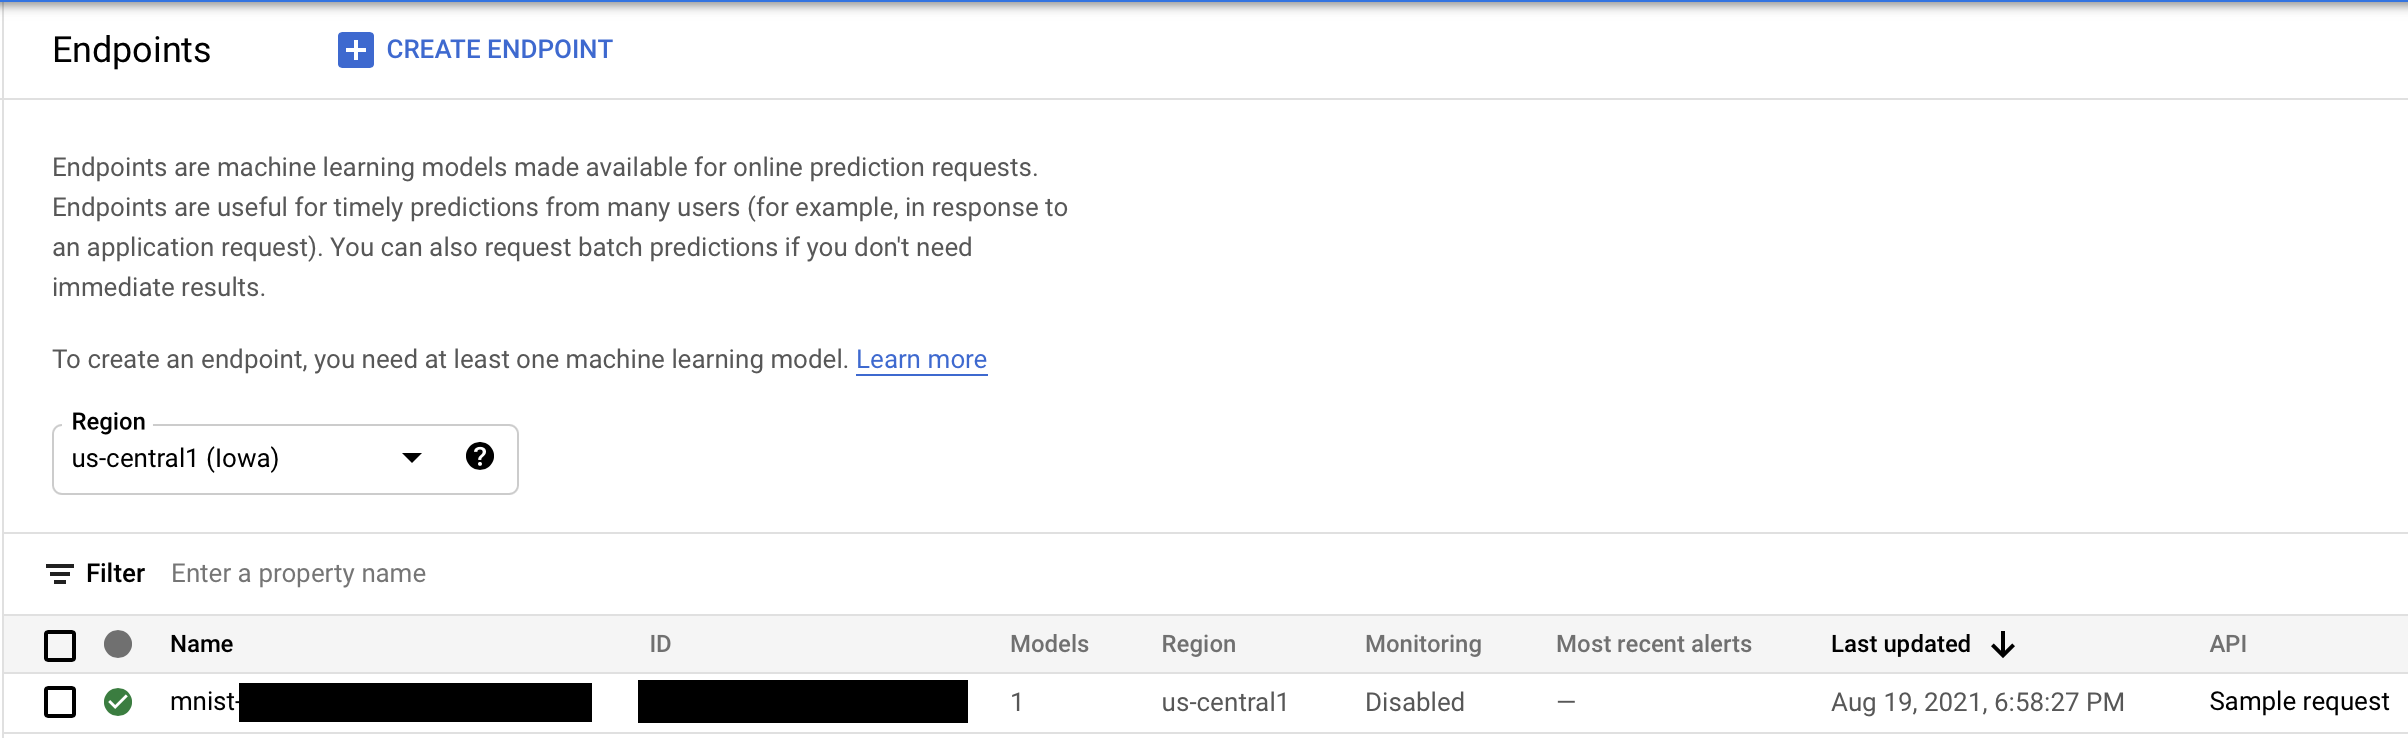

To view the details of the endpoint that is currently deploying, you can simply click on the endpoint name.

Once deployment is successfull, you should be able to see a green tick next to the endpoint name in the above screenshot.

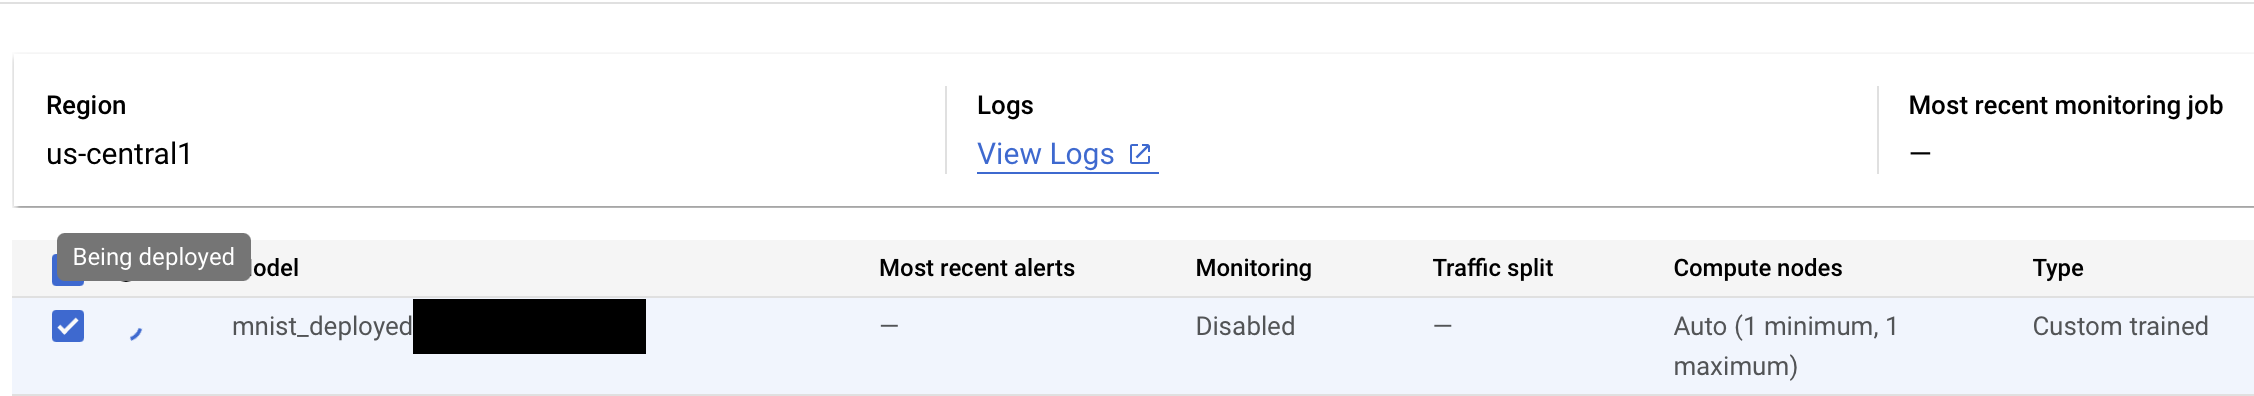

## Make an online prediction request

Send an online prediction request to your deployed model.

### Testing

Get the test dataset and load the images/labels.

Set the batch size to -1 to load the entire dataset.

In [ ]:
import tensorflow_datasets as tfds
import numpy as np

In [ ]:
datasets, info = tfds.load(name='mnist',
                            with_info=True,
                            batch_size=-1,
                            as_supervised=True)

test_dataset = datasets['test']

Load the TensorFlow Dataset as NumPy arrays (images, labels)

In [ ]:
x_test, y_test = tfds.as_numpy(test_dataset)

# Normalize (rescale) the pixel data by dividing each pixel by 255. 
x_test = x_test.astype('float32') / 255.

Ensure the shapes are correct here

In [ ]:
x_test.shape, y_test.shape

In [ ]:
#@title Pick the number of test images
NUM_TEST_IMAGES = 20 #@param {type:"slider", min:1, max:20, step:1}
x_test, y_test = x_test[:NUM_TEST_IMAGES], y_test[:NUM_TEST_IMAGES]

### Send the prediction request

Now that you have test images, you can use them to send a prediction request. Use the `Endpoint` object's `predict` function, which takes the following parameters:

- `instances`: A list of image instances. According to your custom model, each image instance should be a 3-dimensional matrix of floats. This was prepared in the previous step.

The `predict` function returns a list, where each element in the list corresponds to the corresponding image in the request. You will see in the output for each prediction:

- Confidence level for the prediction (`predictions`), between 0 and 1, for each of the ten classes.

You can then run a quick evaluation on the prediction results:
1. `np.argmax`: Convert each list of confidence levels to a label
2. Compare the predicted labels to the actual labels
3. Calculate `accuracy` as `correct/total`

In [ ]:
predictions = endpoint.predict(instances=x_test.tolist())
y_predicted = np.argmax(predictions.predictions, axis=1)

correct = sum(y_predicted == np.array(y_test.tolist()))
accuracy = len(y_predicted)
print(
    f"Correct predictions = {correct}, Total predictions = {accuracy}, Accuracy = {correct/accuracy}"
)

## Undeploy the model

To undeploy your `Model` resource from the serving `Endpoint` resource, use the endpoint's `undeploy` method with the following parameter:

- `deployed_model_id`: The model deployment identifier returned by the endpoint service when the `Model` resource was deployed. You can retrieve the deployed models using the endpoint's `deployed_models` property.

Since this is the only deployed model on the `Endpoint` resource, you can omit `traffic_split`.

In [ ]:
deployed_model_id = endpoint.list_models()[0].id
endpoint.undeploy(deployed_model_id=deployed_model_id)

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Training Job
- Model
- Endpoint
- Cloud Storage Bucket

In [ ]:
delete_training_job = True
delete_model = True
delete_endpoint = True

# Warning: Setting this to true will delete everything in your bucket
delete_bucket = True

# Delete the training job
job.delete()

# Delete the model
model.delete()

# Delete the endpoint
endpoint.delete()

if delete_bucket and "BUCKET_NAME" in globals():
    ! gsutil -m rm -r $BUCKET_NAME